In [16]:
# Bibliotecas a usar
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from scipy.integrate import quad
from scipy.special import beta

In [2]:
# Leer una imagen para importarla al entorno
def read_img(img_path):
    with open(img_path, 'r') as img:
        return cv.imread(img_path, -1)

# Obtener una imagen binarizada a partir de otra mostrando una región específica seleccionada
def get_region(img, region=('bg', 'max', 'min')):
    # Ejecutar un análisis de componentes conectadas para extraer los objetos de la imagen
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4, ltype=cv.CV_16U)
    # Índices de todos los objetos encontrados
    objects = np.arange(num_labels)
    # Extraer el objeto más grande (con área mayor)
    max_object = np.argmax(stats[1::, 4]) + 1
    # Extraer la imagen binarizada elegida
    if region == 'max':
        return np.isin(labels, max_object).astype(np.uint8)
    elif region == 'min':
        # Extraer los objetos más pequeños
        min_objects = np.ma.array(objects[1:], mask=False)
        min_objects.mask[max_object - 1] = True
        min_objects = min_objects.compressed()
        return np.isin(labels, min_objects).astype(np.uint8)
    elif region == 'bg':
        # Extraer el fondo, incluyendo los objetos más pequeños
        bg = np.ma.array(objects, mask=False)
        bg.mask[max_object] = True
        bg = bg.compressed()
        return np.isin(labels, bg).astype(np.uint8)

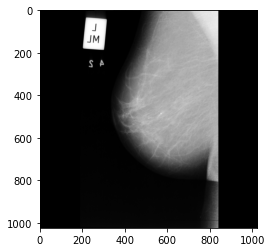

In [3]:
# Ruta de las imágenes originales
base_dir = '../extdata/all-mias/'
all_filenames = os.listdir(base_dir)
imgs_filenames = list()

# Extraer los archivos que corresponden a las imágenes de las mamografías
for filename in all_filenames:
    if filename.endswith('.pgm'):
        imgs_filenames.append(filename)
        
# Reordernar las imágenes alfabéticamente/numéricamente
imgs_filenames.sort()

# Lectura de las imágenes con el parámetro -1 para leer la imagen sin modificar
imgs_orig = list(map(lambda img_filename: read_img(base_dir+img_filename), imgs_filenames))

# Imagen de ejemplo
plt.imshow(imgs_orig[10], cmap='gray')
plt.show()

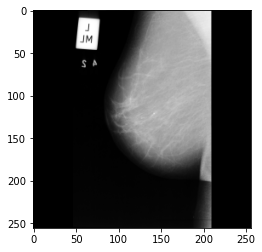

In [4]:
# Reescalar las imágenes para hacerlas más pequeñas (scale down)
imgs_scale = list(map(lambda img_orig: cv.resize(img_orig, (256, 256), interpolation=cv.INTER_AREA), imgs_orig))

# Imagen de ejemplo
plt.imshow(imgs_scale[10], cmap='gray')
plt.show()

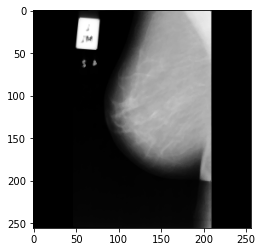

In [5]:
# Aplicar un filtro de mediana a cada una de las imágenes
imgs_filter = list(map(lambda img_scale: cv.medianBlur(img_scale, 3), imgs_scale))

# Imagen de ejemplo
plt.imshow(imgs_filter[10], cmap='gray')
plt.show()

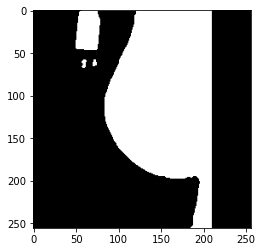

In [6]:
# Obtener del umbral a partir del valor del nivel de gris en la imagen
def T(img):
    H_n = cv.calcHist([img], [0], None, histSize=[256], ranges=(0, 256), accumulate=False).ravel()
    return 0.2 * np.sum(np.arange(0, 256) * H_n) / np.sum(H_n)

# Binarizar la imagen
def binarization(img):
    return np.where(img >= T(img), 1, 0).astype(np.uint8)

# Binarización de las imágenes
imgs_bin = list(map(lambda img_filter: binarization(img_filter), imgs_filter))

# Imagen de ejemplo
plt.imshow(imgs_bin[10], cmap='gray')
plt.show()

In [7]:
# Creación del kernel compuesto por un disco de radio 2
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0
kernel

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

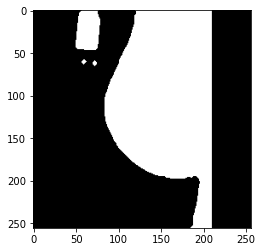

In [8]:
# Aplicar el procesamiento morfológico de apertura sobre las imágenes binarizadas
imgs_mpo = list(map(lambda img_bin: cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel), imgs_bin))

# Imagen de ejemplo
plt.imshow(imgs_mpo[10], cmap='gray')
plt.show()

In [9]:
# Extraer la región del busto
def extract_breast_region(img_scale, img_bin, img_mpo):
    # Obtener la región que no pertenece a la región del busto
    bg_region = get_region(img_mpo, region='bg')
    # Obtener las intensidades de la región que no pertenece a la región del busto
    bg_values = np.ma.array(img_scale, mask=False)
    bg_values.mask = np.where(bg_region == 1, False, True)
    # Calcular el nivel de gris medio de estas áreas
    mean_gray_level = np.mean(bg_values)
    # Modificar las intensidades en la región del fondo
    smaller_objects = get_region(img_mpo, region='bg')
    mod_img_scale = np.where(smaller_objects == 1, mean_gray_level, img_scale).astype(np.uint8)
    # Obtener la región más grande, que corresponde a la región del busto
    breast_region = get_region(img_mpo, region='max')
    return mod_img_scale, breast_region

In [10]:
# Eliminar los objetos que no son parte de la región del busto en las imágenes escaladas
imgs_clean = list()
imgs_bin_clean = list()

for img_scale, img_bin, img_mpo in zip(imgs_scale, imgs_bin, imgs_mpo):
    img_clean, img_bin_clean = extract_breast_region(img_scale, img_bin, img_mpo)
    imgs_clean.append(img_clean)
    imgs_bin_clean.append(img_bin_clean)

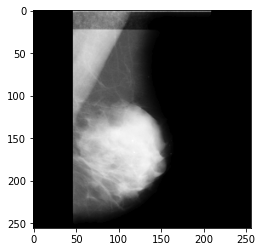

In [12]:
# Imagen de ejemplo (Imagen escalada limpia)
plt.imshow(imgs_clean[1], cmap='gray')
plt.show()

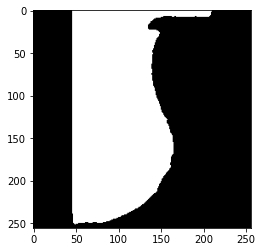

In [14]:
# Imagen de ejemplo (Imagen binarizada limpia)
plt.imshow(imgs_bin_clean[1], cmap='gray')
plt.show()

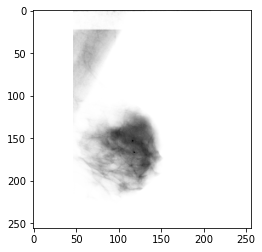

In [23]:
# Hacemos una copia de la imagen limpia 51
img_p = imgs_clean[1].copy().astype(float)

a = 5
b = 2

def BDF(t):
    return (t ** (a - 1)) * ((1 - t) ** (b - 1))

with np.nditer(img_p, op_flags=['readwrite']) as it:
    for x in it:
        x[...], _ = quad(BDF, 0, x) / beta(a, b)
        
plt.imshow(img_p, cmap='gray')

In [20]:
img_p

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])